# Importing all the necessary Libraries


In [9]:
from __future__ import print_function, division

from keras.datasets import fashion_mnist

from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

import numpy as np
import matplotlib.pyplot as plt

# Visualising the dataset


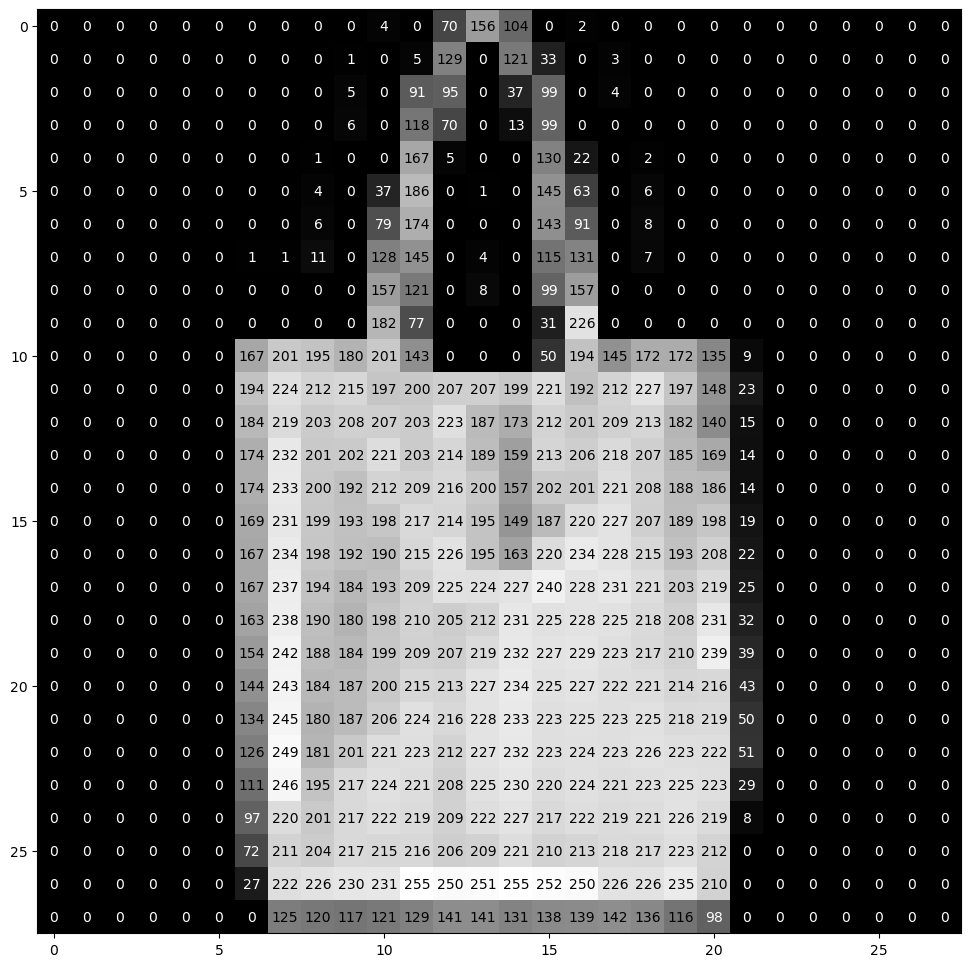

In [10]:
(training, _), (_, _) = fashion_mnist.load_data()

X_train = training/ 127.5-1
X_train = np.expand_dims(X_train, axis=3)   #Rescaling the data to [-1,1]

def visualize_input(img, ax):
    ax.imshow(img, cmap= 'gray')
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            ax.annotate(str(round(img[x][y], 2)), xy = (y, x),
                        horizontalalignment = 'center',
                        verticalalignment = 'center',
                        color = 'white' if img[x][y] < thresh else 'black')

fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(111)
visualize_input(training[3343], ax)


# Building the generator

In [11]:
def build_generator():
    generator = Sequential()
    
    generator.add(Dense(128 * 7 * 7, activation = 'relu', input_dim = 100))
    
    generator.add(Reshape((7, 7, 128)))
    
    generator.add(UpSampling2D())
    
    generator.add(Conv2D(128, kernel_size=3, padding='same', activation='relu'))
    generator.add(BatchNormalization(momentum=0.8))
    generator.add(UpSampling2D())
    
    generator.add(Conv2D(64, kernel_size=3, padding='same', activation='relu'))
    generator.add(BatchNormalization(momentum=0.8))
    
    generator.add(Conv2D(1, kernel_size=3, padding='same', activation='relu'))
    
    generator.summary()
    
    noise = Input(shape=(100,))
    
    fake_image = generator(noise)
    
    return Model(inputs=noise, outputs=fake_image)
    

# Building the Discriminator

In [12]:
def build_discriminator():
    discriminator = Sequential()
    
    discriminator.add(Conv2D(32, kernel_size=3, strides=2, input_shape=(28, 28, 1), padding='same'))
    discriminator.add(LeakyReLU(alpha=0.2))
    discriminator.add(Dropout(0.25))
    
    discriminator.add(Conv2D(64, kernel_size=3, strides=2, padding='same'))
    discriminator.add(ZeroPadding2D(padding = ((0,1),(0,1))))
    discriminator.add(BatchNormalization(momentum = 0.8))
    
    discriminator.add(LeakyReLU(alpha=0.2))
    discriminator.add(Dropout(0.25))
    
    discriminator.add(Conv2D(128, kernel_size=3, strides=2, padding='same'))
    discriminator.add(BatchNormalization(momentum=0.8))
    discriminator.add(LeakyReLU(alpha=0.2))
    discriminator.add(Dropout(0.25))    
    
    discriminator.add(Conv2D(256, kernel_size=3, strides=1, padding='same'))
    discriminator.add(BatchNormalization(momentum=0.8))
    discriminator.add(LeakyReLU(alpha=0.2))
    discriminator.add(Dropout(0.25))
    
    discriminator.add(Flatten())
    discriminator.add(Dense(1, activation='sigmoid'))
    
    img = Input(shape=(28,28,1))
    probability = discriminator(img)
    return Model(inputs=img, outputs=probability)

# Building the Combined Model


In [13]:
optimizer = Adam(learning_rate=0.0002, beta_1=0.5)

discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

discriminator.trainable = False

generator = build_generator()

z = Input(shape=(100,))
img = generator(z)

valid = discriminator(img)

combined = Model(inputs = z, outputs = valid)
combined.compile(loss='binary_crossentropy', optimizer = optimizer)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 6272)              633472    
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d_2 (UpSampling  (None, 14, 14, 128)      0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 14, 14, 128)       147584    
                                                                 
 batch_normalization_8 (Batc  (None, 14, 14, 128)      512       
 hNormalization)                                                 
                                                                 
 up_sampling2d_3 (UpSampling  (None, 28, 28, 128)     

## Plotting function

In [25]:
def plot_generated_images(epoch, generator, examples=100, dim=(10, 10), figsize=(10,10)):
    noise = np.random.normal(0, 1, size=[examples,100])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples, 28, 28)
    
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image_epoch_%d.png' % epoch)

# Building the training function 

In [15]:
def train(epochs, batch_size=128, save_interval=50):
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))
    
    for epoch in range(epochs):
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]
        
        noise = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(noise)
        
        d_loss_real = discriminator.train_on_batch(imgs, valid)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        g_loss = combined.train_on_batch(noise, valid)
        
        print("%d [D loss: %f, acc: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
        
        if epoch % save_interval == 0:
            plot_generated_images(epoch, generator)

1/1 [==============================] - 0s 51ms/step


2023-03-21 23:20:12.800428: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_3/sequential_2/dropout_4/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-03-21 23:20:15.702135: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_5/model_3/sequential_2/dropout_4/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


0 [D loss: 0.000018, acc: 100.00%] [G loss: 3.405031]
1/1 [==============================] - 0s 30ms/step
1 [D loss: 0.000030, acc: 100.00%] [G loss: 3.802498]
1/1 [==============================] - 0s 32ms/step
2 [D loss: 0.000032, acc: 100.00%] [G loss: 3.319254]
1/1 [==============================] - 0s 62ms/step
3 [D loss: 0.000017, acc: 100.00%] [G loss: 2.857189]
1/1 [==============================] - 0s 48ms/step
4 [D loss: 0.000028, acc: 100.00%] [G loss: 3.137348]
1/1 [==============================] - 0s 31ms/step
5 [D loss: 0.000025, acc: 100.00%] [G loss: 3.350125]
1/1 [==============================] - 0s 31ms/step
6 [D loss: 0.000018, acc: 100.00%] [G loss: 3.093834]
1/1 [==============================] - 0s 36ms/step
7 [D loss: 0.000009, acc: 100.00%] [G loss: 3.010991]
1/1 [==============================] - 0s 42ms/step
8 [D loss: 0.000021, acc: 100.00%] [G loss: 3.283232]
1/1 [==============================] - 0s 47ms/step
9 [D loss: 0.000048, acc: 100.00%] [G loss: 3.

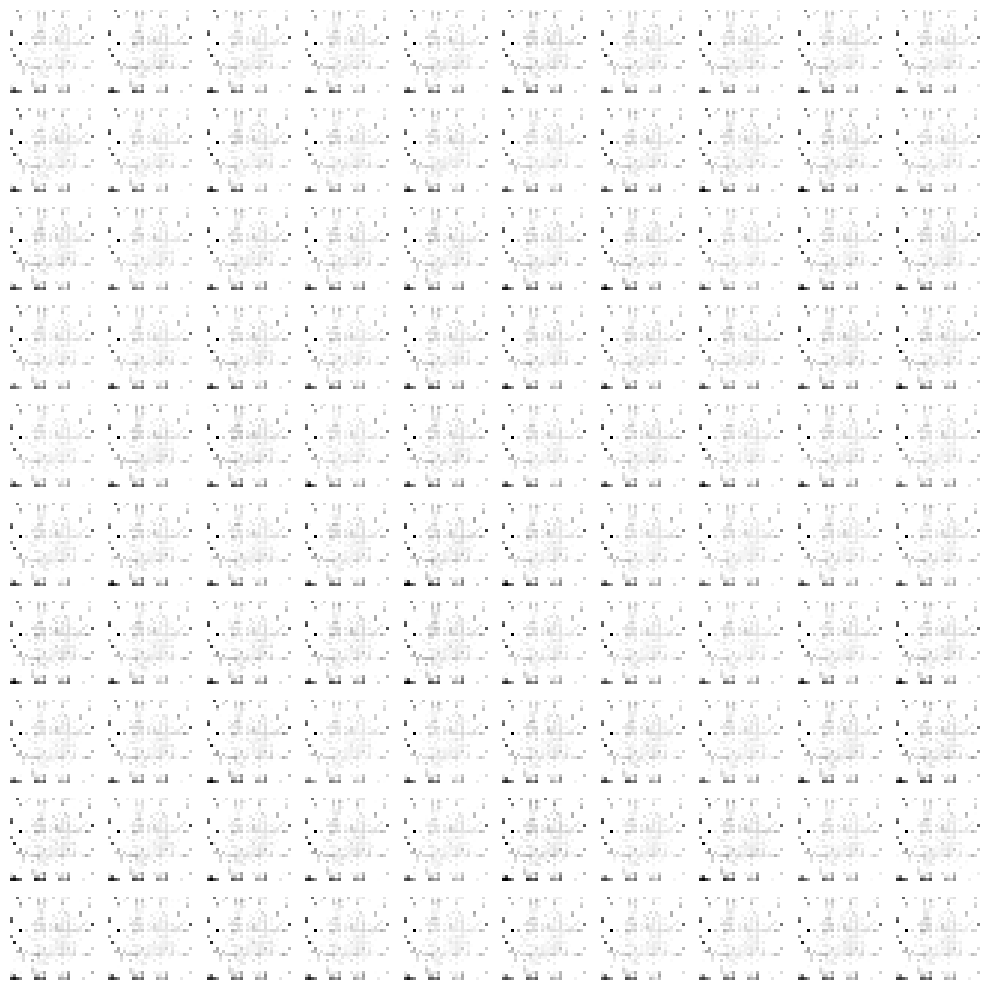

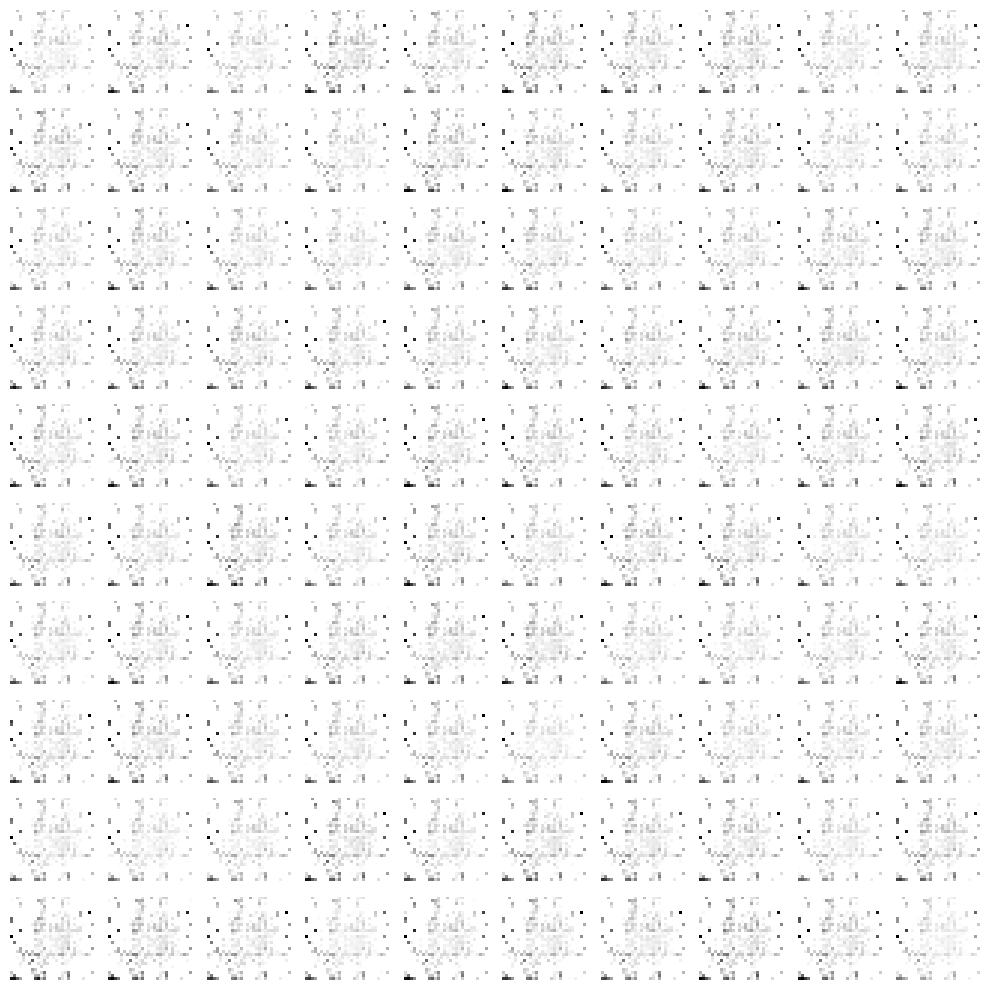

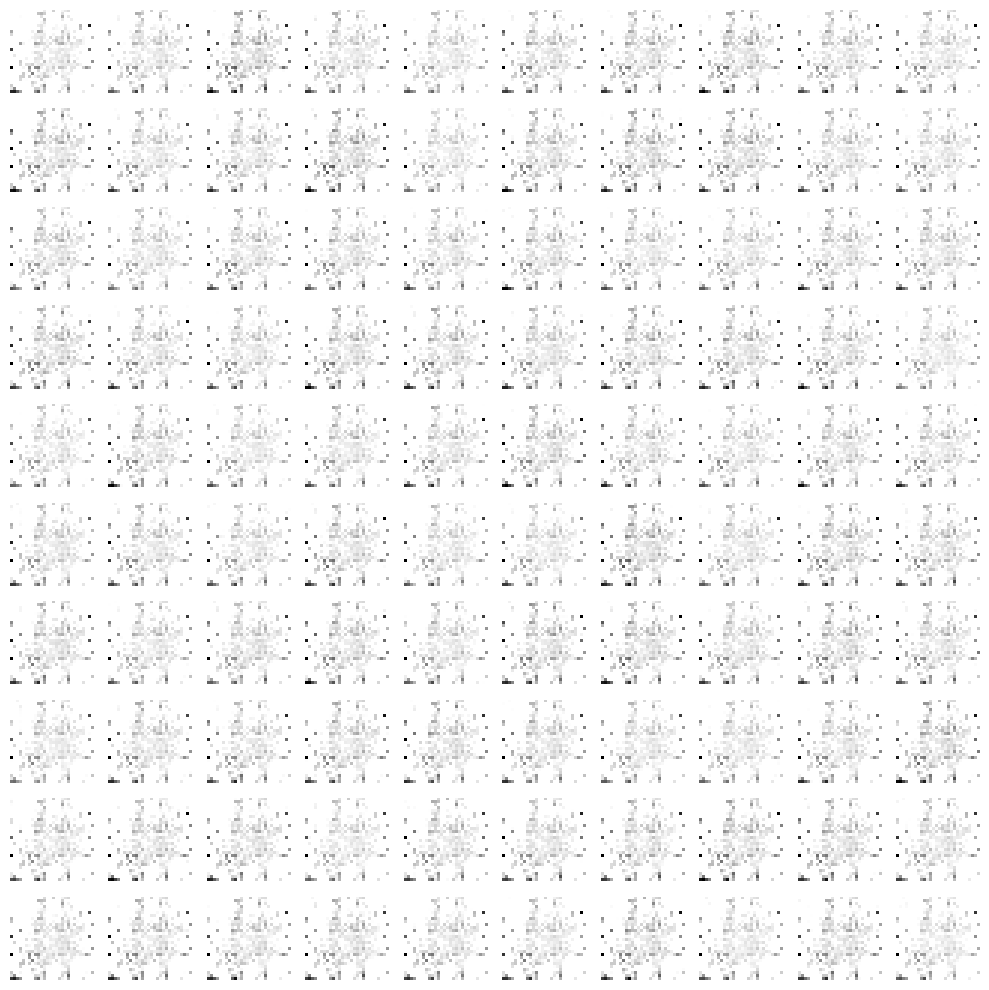

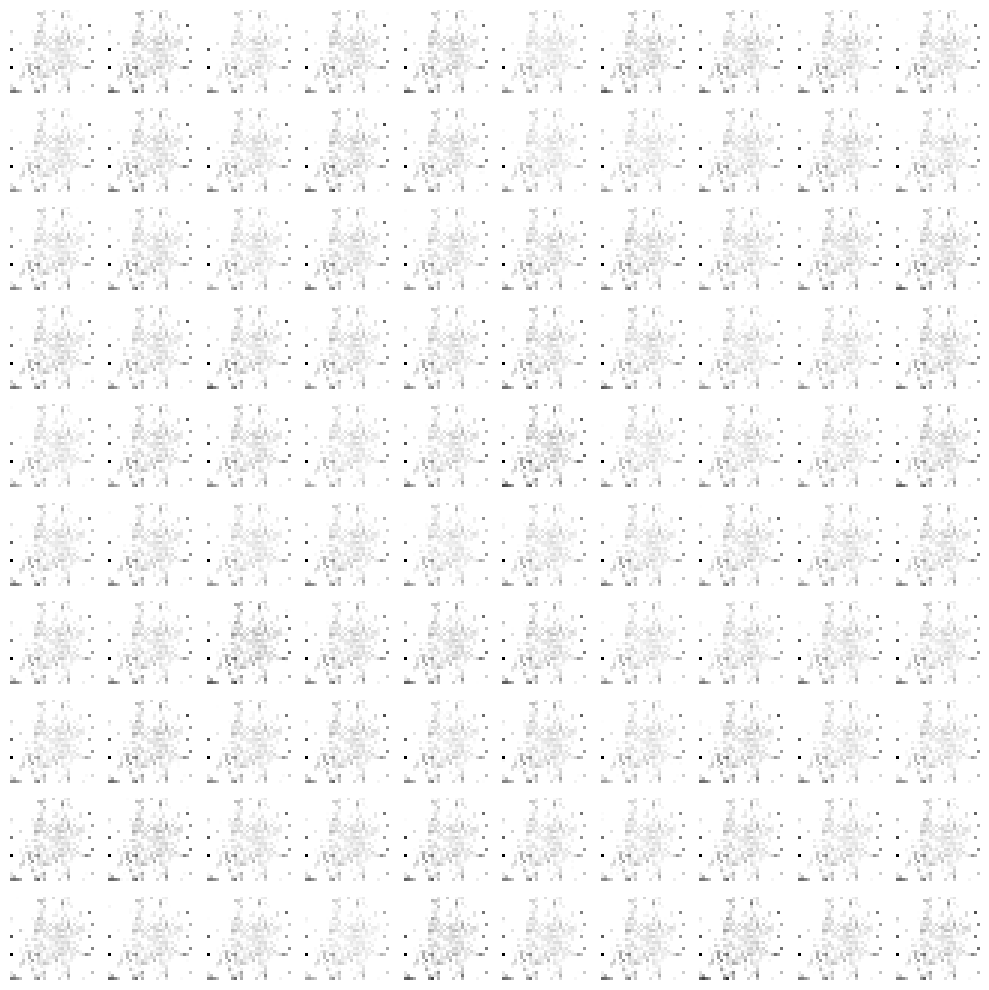

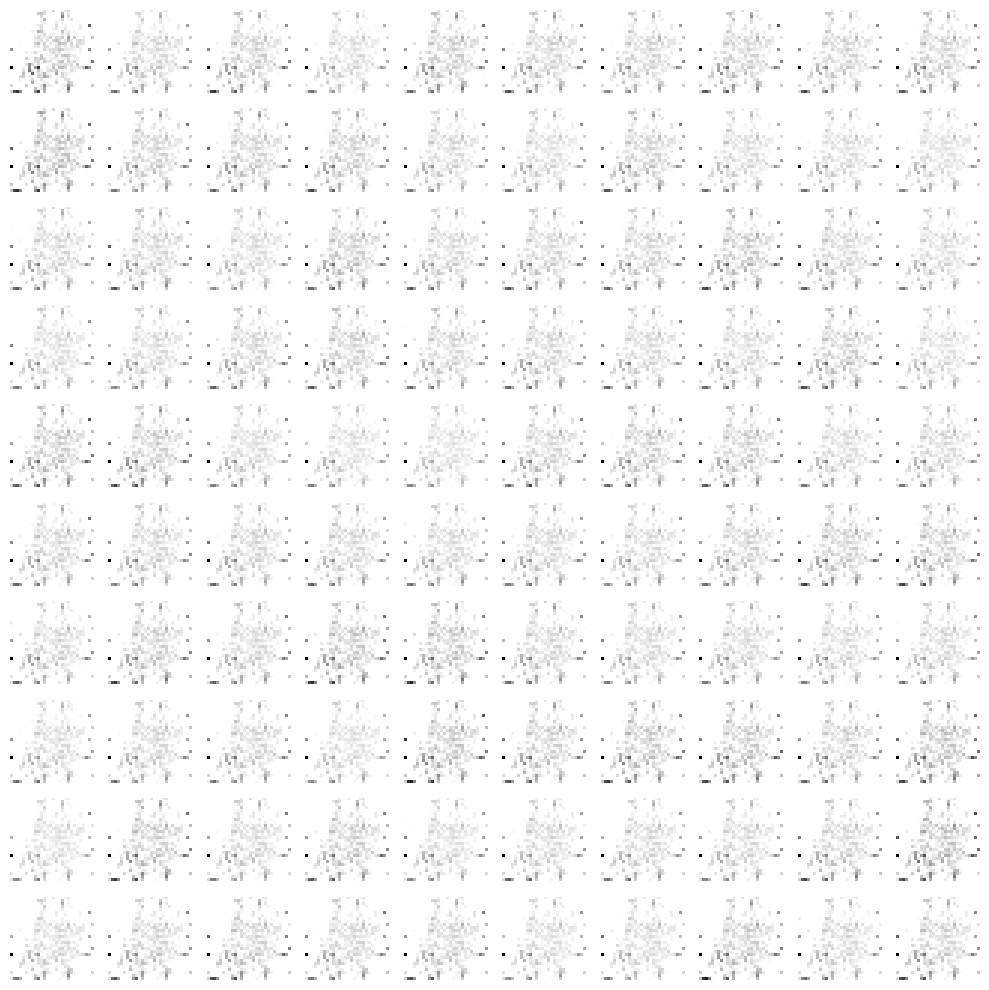

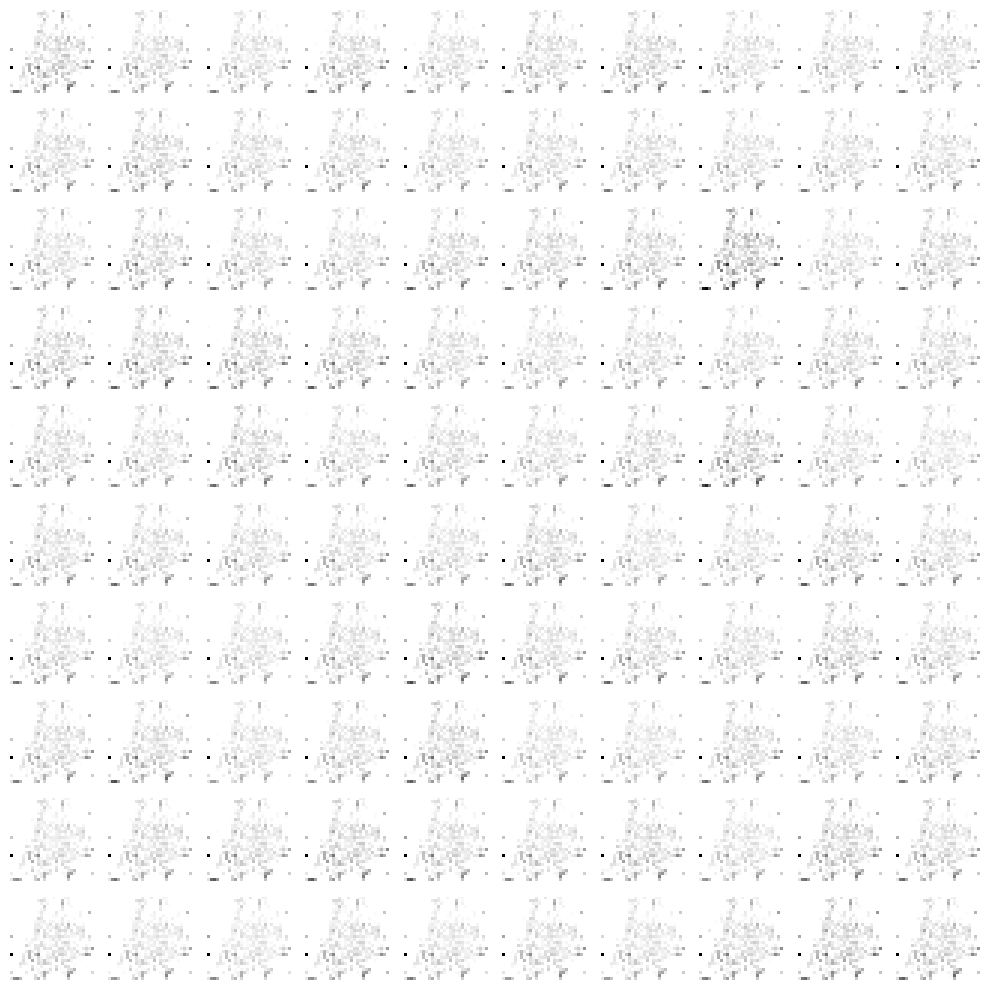

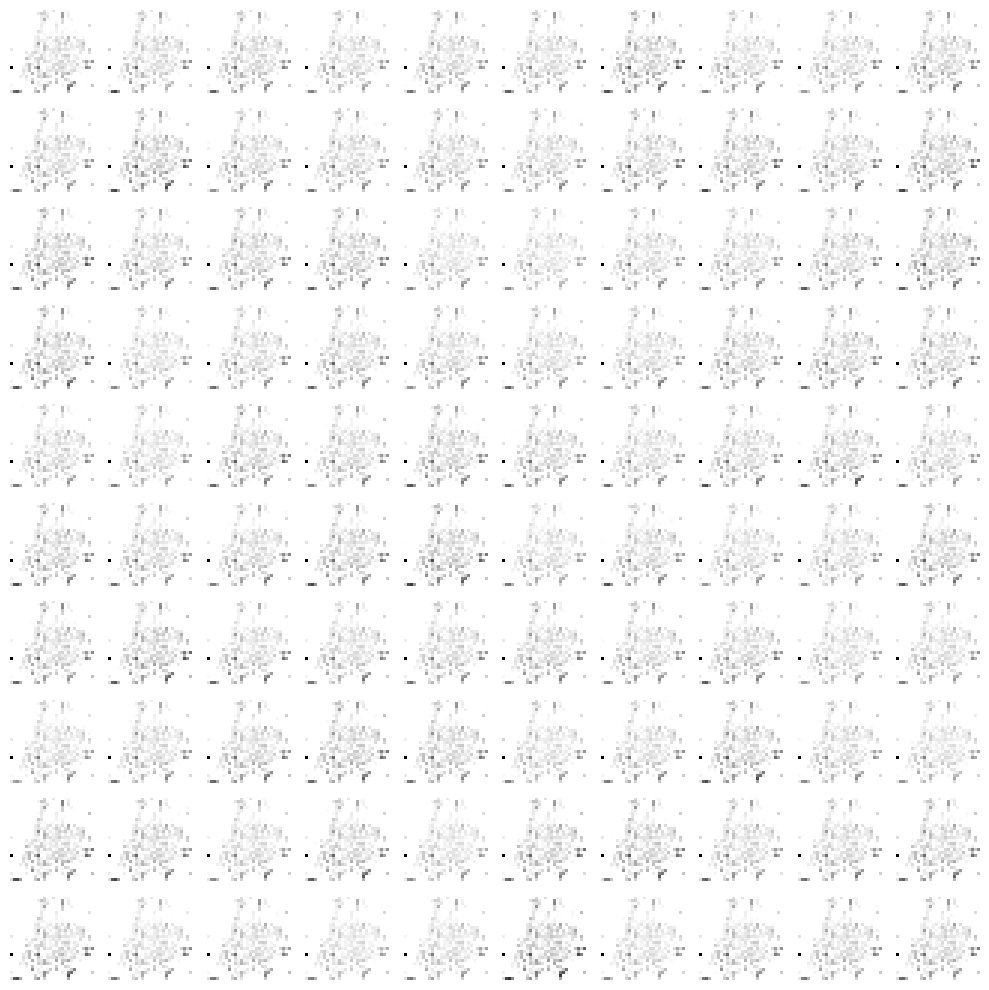

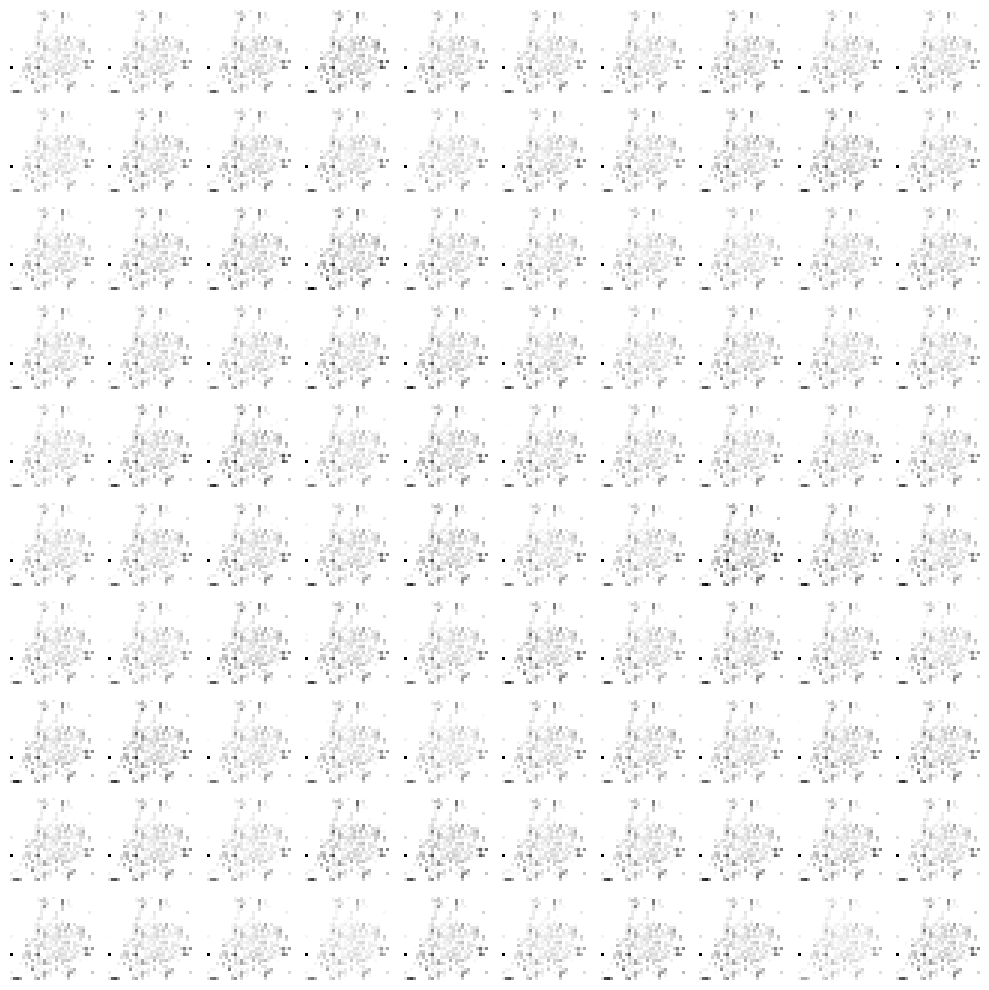

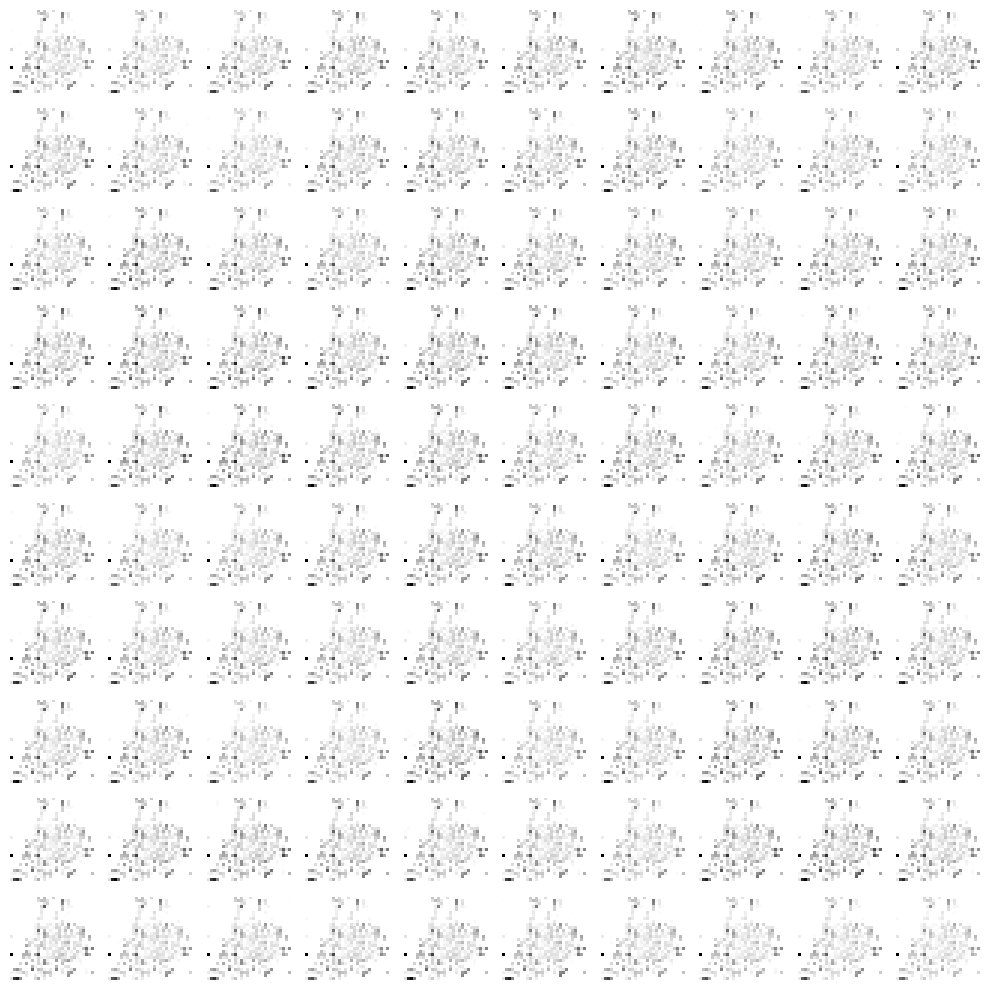

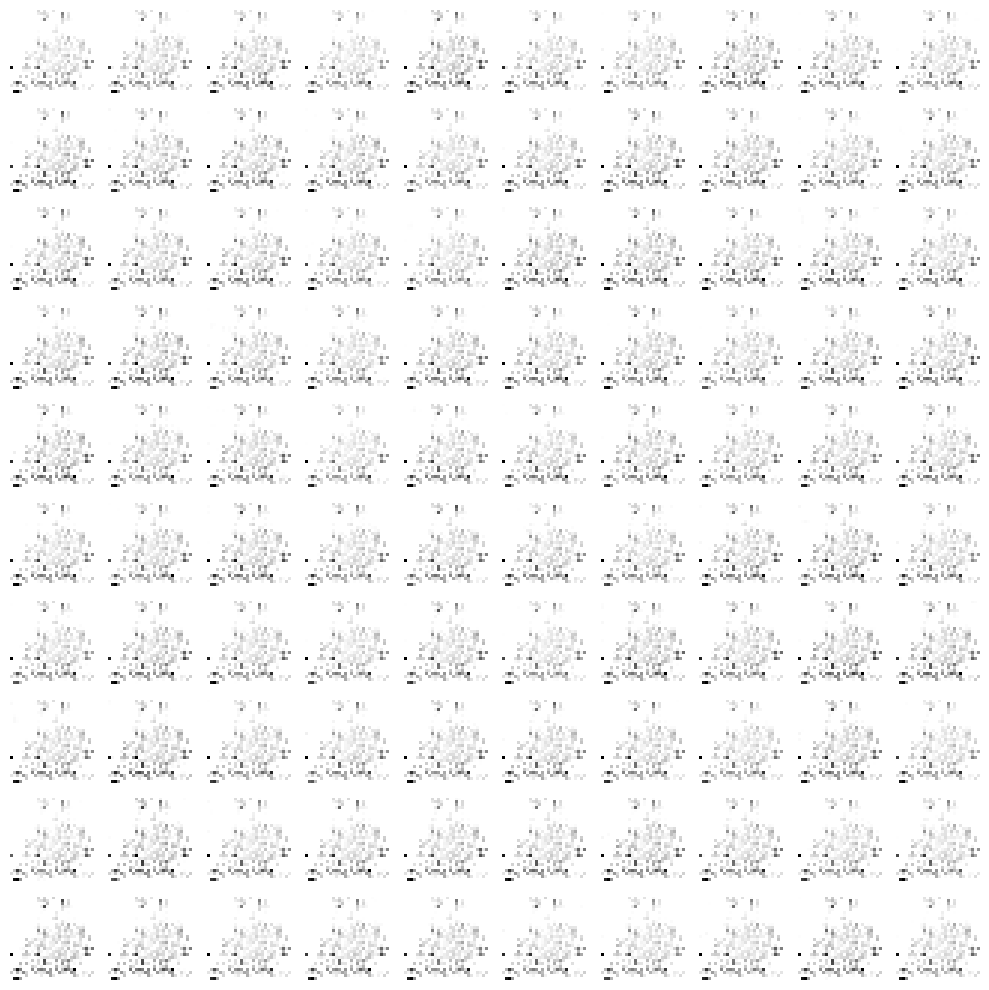

In [27]:
train(epochs=1000, batch_size=32, save_interval=100)